# High-Accuracy Fruit Classification Using TensorFlow

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
import os
from tqdm import tqdm

In [18]:
# Set dataset paths and image size
train_path = 'Fruits_Vegetables/train'
val_path = 'Fruits_Vegetables/validation'
test_path = 'Fruits_Vegetables/test'
img_height = 180
img_width = 180

In [19]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=32
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=32
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=32
)
class_names = train_ds.class_names

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [20]:
# Data augmentation for improved generalization
augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [21]:
# Model definition with data augmentation
model = Sequential([
    augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names))
])

In [22]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [23]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [24]:
# Train the model with early stopping and tqdm progress bar
from tqdm import trange
import time

epochs = 25
epoch_times = []
steps_per_epoch = len(train_ds)
val_steps = len(val_ds)

history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in trange(epochs, desc='Epochs'):
    start = time.time()
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=1,
        callbacks=[early_stopping],
        verbose=0
    )
    end = time.time()
    epoch_times.append(end - start)
    # Collect history
    for k in history.keys():
        history[k].append(hist.history[k][0])
    # Early stopping check
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping at epoch {epoch+1}")
        break



# Create DataFrame for results
results_df = pd.DataFrame({
    'Epoch': range(1, len(history['loss'])+1),
    'Time (s)': epoch_times,
    'Train Loss': history['loss'],
    'Train Acc': history['accuracy'],
    'Val Loss': history['val_loss'],
    'Val Acc': history['val_accuracy']
})

print(f"Model trained for {len(history['loss'])} epochs")

# Save the trained model
model.save('Image_classify.keras')
print("Model saved as 'Image_classify.keras'")

Epochs: 100%|██████████| 25/25 [10:28<00:00, 25.13s/it]

Model trained for 25 epochs
Model saved as 'Image_classify.keras'


In [25]:
display(results_df)

,Epoch,Time (s),Train Loss,Train Acc,Val Loss,Val Acc
0,1,24.866246,3.462977,0.056822,3.184862,0.088319
1,2,22.281733,2.903762,0.163724,2.531022,0.287749
2,3,22.337704,2.519602,0.250080,2.051114,0.387464
3,4,22.330405,2.304407,0.313002,1.829366,0.455840
4,5,22.310702,2.218705,0.327127,1.694164,0.484330
5,6,23.433619,2.130166,0.349599,1.599543,0.518519
6,7,24.995915,2.044870,0.382344,1.579876,0.475783
7,8,25.874368,1.973768,0.401605,1.530471,0.504274
8,9,24.831066,1.927938,0.415409,1.413330,0.547009
9,10,25.117780,1.839375,0.437560,1.418488,0.509971


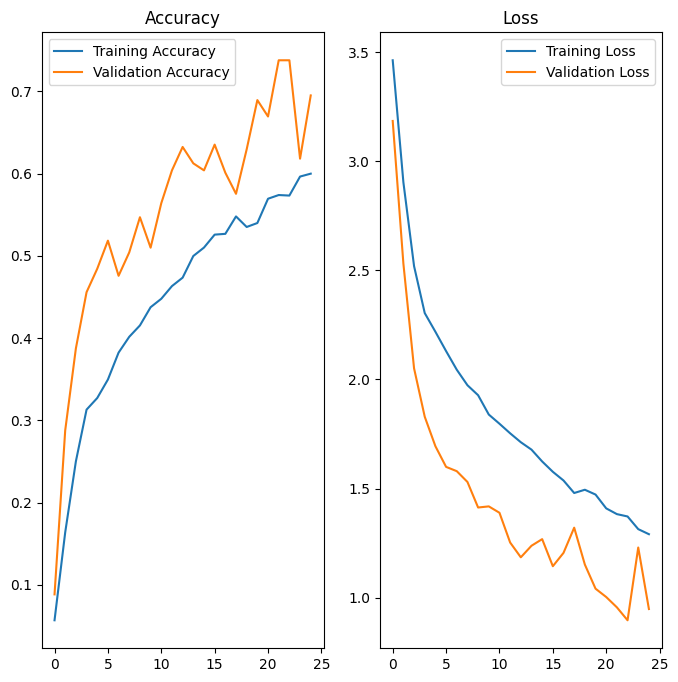

In [26]:
# Plot training history
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


<Figure size 1000x1000 with 0 Axes>

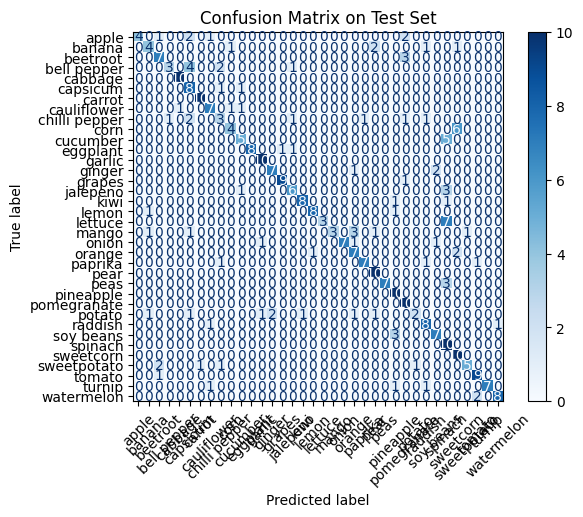

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions for test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()

In [ ]:
# Batch prediction utility function

def predict_multiple_images(image_paths, model, img_height, img_width, class_names):
    results = []
    for img_path in image_paths:
        img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_batch = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_batch)
        scores = tf.nn.softmax(predictions[0]).numpy()  # Convert to numpy array
        top_scores_idx = np.argsort(scores)[-3:][::-1]
        top_scores = scores[top_scores_idx]
        result = {
            'image': os.path.basename(img_path),
            'prediction': class_names[np.argmax(scores)],
            'confidence': round(float(np.max(scores) * 100), 2),
            'top_3_predictions': [class_names[idx] for idx in top_scores_idx],
            'top_3_scores': [round(float(score * 100), 2) for score in top_scores]
        }
        results.append(result)
    return pd.DataFrame(results)

# Example usage:
test_images = ['Apple.jpg', 'Banana.jpg', 'corn.jpg']
results_df = predict_multiple_images(test_images, model, img_height, img_width, class_names)
display(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


,image,prediction,confidence,top_3_predictions,top_3_scores
0,Apple.jpg,apple,91.13,"[apple, pomegranate, tomato]","[91.13, 4.27, 1.07]"
1,Banana.jpg,pineapple,25.01,"[pineapple, lemon, cauliflower]","[25.01, 22.48, 18.07]"
2,corn.jpg,sweetcorn,59.97,"[sweetcorn, corn, pineapple]","[59.97, 33.99, 3.51]"


In [1]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc*100:.2f}%")

NameError: name 'model' is not defined

Analyzing train dataset...

TRAIN DATASET SUMMARY:


,class_name,num_files,file_size_min_kb,file_size_max_kb,file_size_avg_kb,min_resolution_str,max_resolution_str
0,apple,68,10.33,7554.87,678.39,250x249,4900x4965
1,banana,75,9.23,8574.86,541.47,200x243,7360x4912
2,beetroot,88,9.95,7351.73,481.88,225x179,3456x5184
3,bell pepper,90,13.31,6606.99,680.36,220x147,5616x3744
4,cabbage,92,16.44,7111.78,584.22,151x157,4288x3216
5,capsicum,89,11.62,3165.09,343.27,200x300,4681x3100
6,carrot,82,17.71,9512.12,443.99,256x256,3888x2592
7,cauliflower,79,8.67,4438.65,360.45,172x189,4928x3264
8,chilli pepper,87,17.53,1994.75,226.01,208x208,5262x3720
9,corn,87,15.34,8351.49,768.00,217x315,3445x5178


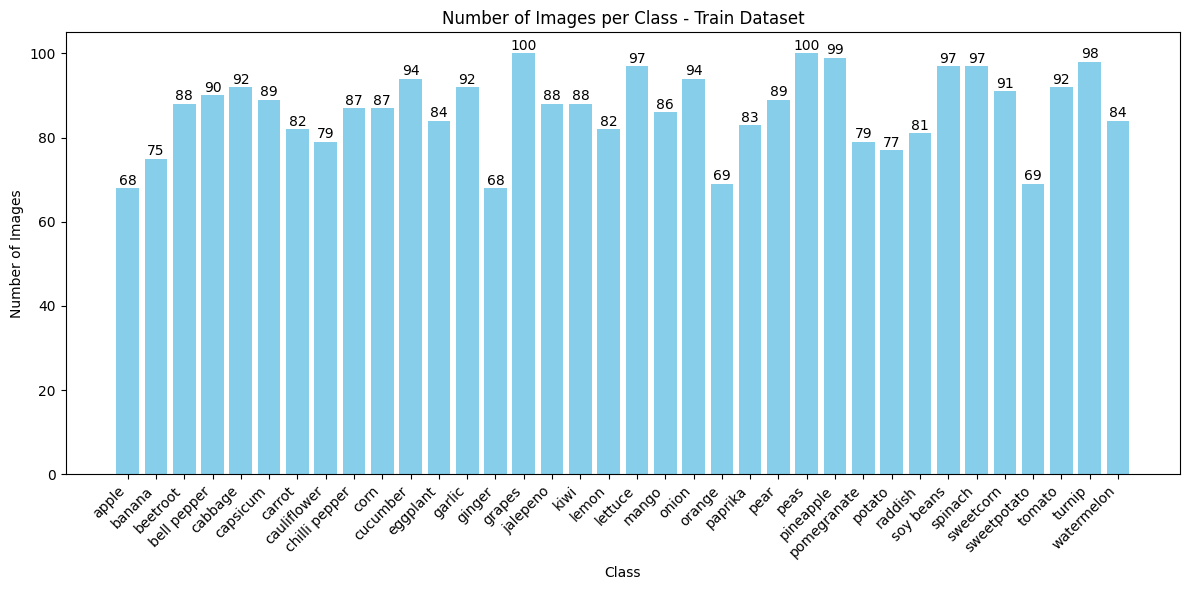

Analyzing validation dataset...

VALIDATION DATASET SUMMARY:


,class_name,num_files,file_size_min_kb,file_size_max_kb,file_size_avg_kb,min_resolution_str,max_resolution_str
0,apple,10,22.62,2569.77,773.08,800x863,6228x4152
1,banana,9,8.77,220.54,67.50,480x360,1200x1057
2,beetroot,10,170.62,2389.13,725.92,768x1024,3264x2448
3,bell pepper,9,67.06,6606.99,2332.20,800x800,5616x3744
4,cabbage,10,94.08,2275.43,725.05,900x900,3888x2592
5,capsicum,10,62.03,2400.33,639.91,1200x801,3607x2722
6,carrot,9,57.14,373.04,202.11,1280x720,1920x1275
7,cauliflower,10,89.76,1883.77,452.54,800x900,3276x3276
8,chilli pepper,9,78.67,1764.90,535.15,800x800,3264x2448
9,corn,10,138.47,6602.03,1217.18,1000x750,5016x3424


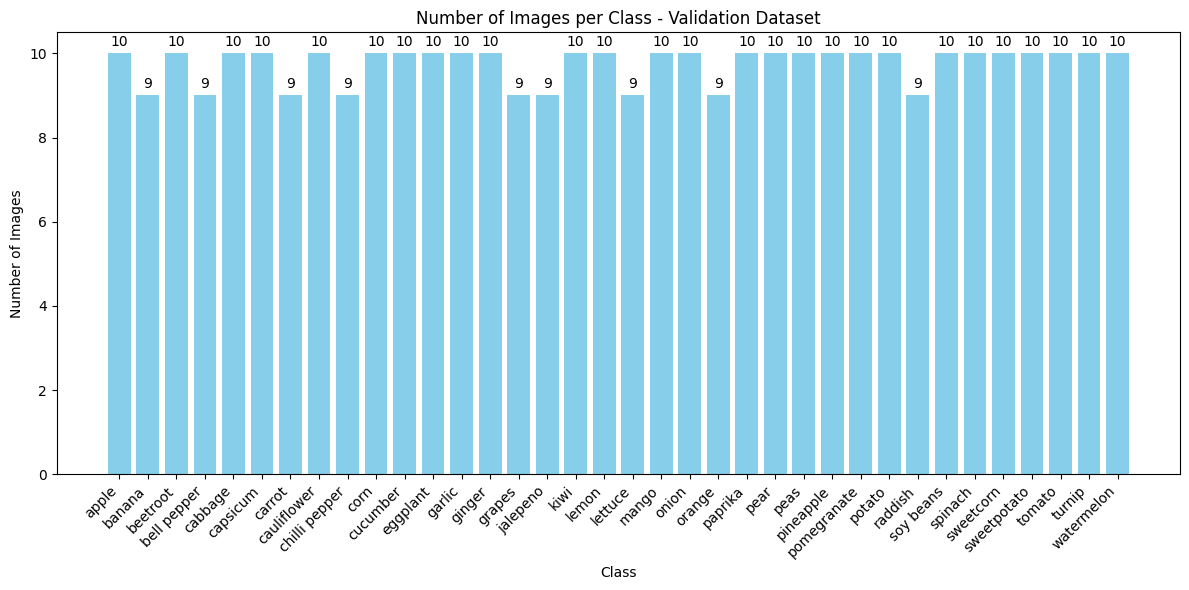

Analyzing test dataset...

TEST DATASET SUMMARY:


,class_name,num_files,file_size_min_kb,file_size_max_kb,file_size_avg_kb,min_resolution_str,max_resolution_str
0,apple,10,22.62,2569.77,773.08,800x863,6228x4152
1,banana,9,8.77,220.54,76.41,480x360,1200x1057
2,beetroot,10,170.62,2389.13,725.92,768x1024,3264x2448
3,bell pepper,10,67.06,6606.99,2106.53,800x800,5616x3744
4,cabbage,10,94.08,2275.43,725.05,900x900,3888x2592
5,capsicum,10,62.03,2400.33,639.91,1200x801,3607x2722
6,carrot,10,57.14,373.04,189.96,616x924,1920x1275
7,cauliflower,10,89.76,1883.77,452.54,800x900,3276x3276
8,chilli pepper,10,63.06,1764.90,487.95,800x800,3264x2448
9,corn,10,138.47,6602.03,1217.67,1000x750,5016x3424


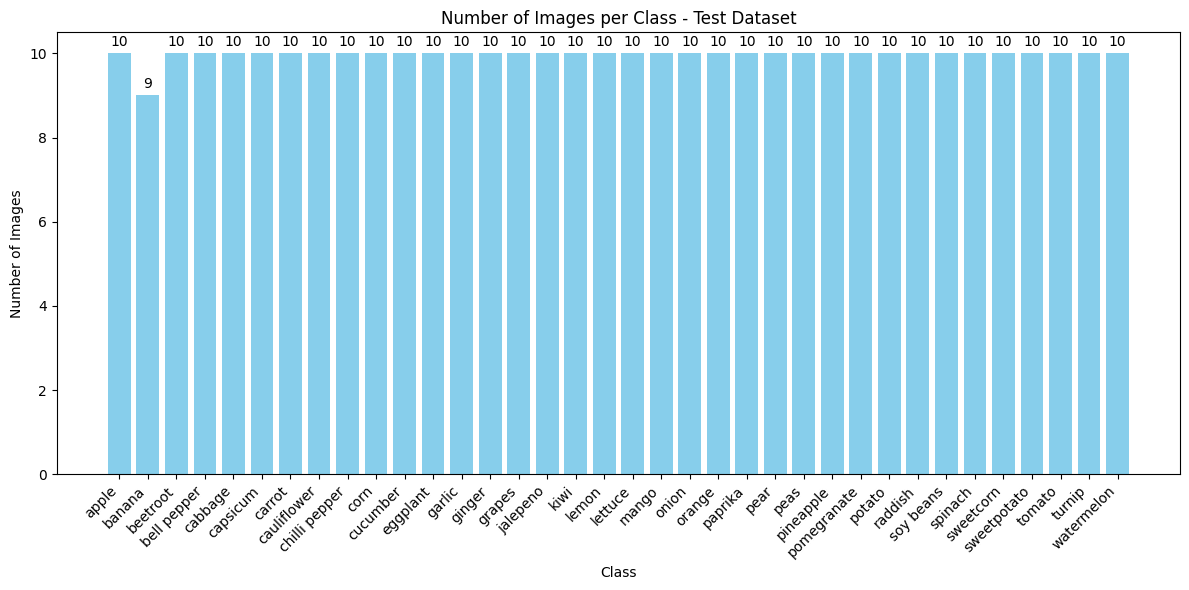


Analysis complete! Comprehensive results saved to CSV files and 'complete_dataset_report.txt'


In [ ]:
# # Import additional libraries needed for analysis
# import os
# from PIL import Image
# import pandas as pd
# import matplotlib.pyplot as plt

# # Function to analyze the image dataset
# def analyze_image_dataset(base_dir, class_names):
#     results = []
    
#     # Analyze each class
#     for class_name in class_names:
#         class_path = os.path.join(base_dir, class_name)
#         files = os.listdir(class_path)
#         image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        
#         # Initialize tracking variables
#         file_sizes = []
#         resolutions = []
        
#         # Analyze each image
#         for img_file in image_files:
#             img_path = os.path.join(class_path, img_file)
            
#             # Get file size in KB
#             file_size = os.path.getsize(img_path) / 1024  # KB
#             file_sizes.append(file_size)
            
#             # Get image resolution
#             with Image.open(img_path) as img:
#                 width, height = img.size
#                 resolutions.append((width, height))
        
#         # Compile results
#         result = {
#             'class_name': class_name,
#             'num_files': len(image_files),
#             'file_size_min_kb': round(min(file_sizes), 2) if file_sizes else 0,
#             'file_size_max_kb': round(max(file_sizes), 2) if file_sizes else 0,
#             'file_size_avg_kb': round(np.mean(file_sizes), 2) if file_sizes else 0,
#             'min_resolution': min(resolutions, key=lambda x: x[0]*x[1]) if resolutions else (0, 0),
#             'max_resolution': max(resolutions, key=lambda x: x[0]*x[1]) if resolutions else (0, 0),
#             'sample_files': image_files[:3] if len(image_files) > 3 else image_files
#         }
#         results.append(result)
    
#     return results

# # Analyze all three datasets
# datasets = {
#     'train': train_path,
#     'validation': val_path,
#     'test': test_path
# }

# all_results = {}

# # Run analysis for each dataset
# for dataset_name, dataset_path in datasets.items():
#     print(f"Analyzing {dataset_name} dataset...")
#     results = analyze_image_dataset(dataset_path, class_names)
#     all_results[dataset_name] = results
    
#     # Convert to dataframe
#     df = pd.DataFrame(results)
#     df['min_resolution_str'] = df['min_resolution'].apply(lambda x: f"{x[0]}x{x[1]}")
#     df['max_resolution_str'] = df['max_resolution'].apply(lambda x: f"{x[0]}x{x[1]}")
    
#     # Display summary for this dataset
#     print(f"\n{dataset_name.upper()} DATASET SUMMARY:")
#     display(df[['class_name', 'num_files', 'file_size_min_kb', 
#                 'file_size_max_kb', 'file_size_avg_kb', 
#                 'min_resolution_str', 'max_resolution_str']])
    
#     # Save to CSV
#     df.to_csv(f'{dataset_name}_dataset_analysis.csv', index=False)
    
#     # Plot distribution
#     plt.figure(figsize=(12, 6))
#     bars = plt.bar(df['class_name'], df['num_files'], color='skyblue')
#     plt.title(f'Number of Images per Class - {dataset_name.capitalize()} Dataset')
#     plt.xlabel('Class')
#     plt.ylabel('Number of Images')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
    
#     # Add count labels on bars
#     for bar in bars:
#         height = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
#                 f'{int(height)}', ha='center', va='bottom')
    
#     plt.show()

# # Create a comprehensive report
# with open('complete_dataset_report.txt', 'w') as f:
#     f.write("COMPLETE DATASET ANALYSIS REPORT\n")
#     f.write("===============================\n\n")
    
#     for dataset_name, results in all_results.items():
#         f.write(f"{dataset_name.upper()} DATASET\n")
#         f.write("-" * 20 + "\n\n")
        
#         for item in results:
#             f.write(f"CLASS: {item['class_name']}\n")
#             f.write(f"Number of files: {item['num_files']}\n")
#             f.write(f"File size range: {item['file_size_min_kb']}KB to {item['file_size_max_kb']}KB (avg: {item['file_size_avg_kb']}KB)\n")
#             min_res = f"{item['min_resolution'][0]}x{item['min_resolution'][1]}"
#             max_res = f"{item['max_resolution'][0]}x{item['max_resolution'][1]}"
#             f.write(f"Resolution range: {min_res} to {max_res}\n")
#             f.write(f"Sample files: {', '.join(str(x) for x in item['sample_files'])}\n\n")
        
#         f.write("\n" + "="*50 + "\n\n")

# print(f"\nAnalysis complete! Comprehensive results saved to CSV files and 'complete_dataset_report.txt'")